## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [16]:
import requests
import pandas as pd
import random
from datetime import datetime
from dateutil.relativedelta import relativedelta
import sys

import time

class API:
    def __init__(self, key, period='annual', limit=5):
        self.base_url = 'https://financialmodelingprep.com/'
        self.params = {
            'apikey': key,
            'period': period,
            'limit': limit,
        }
        self.alwaysCols = ["symbol", "date"]

        # keeps tracks of the time each api call was made (so that we know whether we go over the api call limit)
        self.apiCalls = []

        if limit == None:
            del self.params['limit']

    def overApiCallLimit(self):
        API_CALL_LIMIT = 299 # call limit per minute
        calls = self.apiCalls
        length = len(calls)
        if length < API_CALL_LIMIT:
            return False

        lastTimeIndex = length - API_CALL_LIMIT
        lastTime = calls[lastTimeIndex]

        oneMinuteAgo = datetime.now() - relativedelta(seconds = 65) # datetime.now()
        # if the last time is more recent than one minute ago
        return lastTime >= oneMinuteAgo

    def waitForMoreApiCalls(self):
        if self.overApiCallLimit():
            print("Waiting for more API calls to be available...")
            time.sleep(65)

    def getNumApiCalls(self):
        return len(self.apiCalls)

    def request(self, url):
        print("Making API call request...")
        self.waitForMoreApiCalls()
        r = requests.get(url, params=self.params)

        if r.status_code != 200:
            raise Exception('API did not return a valid response')
        else:
            self.apiCalls.append(datetime.now())

        return r

    def getDataFrameUnordered(self, endpoint): # makes api calls (helper method)
        r = self.request(endpoint)

        print("Request result: ")
        print(r)

        try:
            df = pd.json_normalize(r.json())
        except ValueError:
            raise Exception("Bad URL or API Key!")

        return df

    def getDataFrame(self, endpoint): # makes api calls (helper method)
        df = self.getDataFrameUnordered(endpoint)

        if df.empty:
            raise ValueError("Error, empty dataframe")

        # df = df.reindex(index=df.index[::-1])
        df.sort_values(by=['date'], inplace=True, ascending=True)
        df.reset_index(drop=True, inplace=True)
        return df

    def getRatios(self, ticker):
        endpoint = self.base_url + 'api/v3/ratios/' + ticker
        wantedCols = [
            "currentRatio", "quickRatio", "grossProfitMargin", "operatingProfitMargin", "returnOnAssets",
            "returnOnEquity", "returnOnCapitalEmployed", "debtEquityRatio", "priceToBookRatio", "priceToSalesRatio",
            "priceEarningsRatio", "priceEarningsToGrowthRatio", "priceToOperatingCashFlowsRatio"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getGrowths(self, ticker): # makes api call
        endpoint = self.base_url + 'api/v3/income-statement-growth/' + ticker
        wantedCols = [
            "growthRevenue", "growthCostOfRevenue", "growthGrossProfit", "growthGrossProfitRatio",
            "growthOperatingExpenses", "growthEBITDA", "growthOperatingIncome", "growthNetIncome",
            "growthEPS"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getValues(self, ticker): # makes API call
        endpoint = self.base_url + 'api/v3/enterprise-values/' + ticker
        wantedCols = [
            "marketCapitalization", "enterpriseValue"
        ]
        df = self.getDataFrame(endpoint)
        df = df[self.alwaysCols + wantedCols]
        return df

    def getFinStat(self, ticker, limit): # makes API call
        self.params['limit'] = limit
        self.params['period'] = 'quarter'
        endpoint = self.base_url + 'api/v3/income-statement/' + ticker
        return self.getDataFrame(endpoint)

    def getSamples(self, ticker): # makes API calls
        ratios = self.getRatios(ticker)
        growths = self.getGrowths(ticker)
        values = self.getValues(ticker)

        merge = pd.merge(ratios, growths, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"])
        merge = pd.merge(merge, values, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"])

        return merge

    def getRandTickers(self, num): # makes api calls
        endpoint = self.base_url + 'api/v3/available-traded/list'
        tickers = pd.DataFrame(self.request(endpoint).json())
        rowIdx = random.sample(range(0, len(tickers)), num)

        return list(tickers.iloc[rowIdx]['symbol'])

    def getSamplesFromTickers(self, tickers, samplesPerTicker=5, maxTickers=10): # makes API calls
        '''
        tickers: list Creates dataframe of samples from list of tickers
        samplesPerTicker: int Number of rows of data to get per ticker
        '''
        result = pd.DataFrame()
        i = 0

        for t in tickers:
            if i >= maxTickers:
                break

            try:
                oneYearAgo = (datetime.today() - relativedelta(years=1, months=6)).strftime('%Y-%m-%d')
                df = self.getSamples(t)
                df = df[df['date'] < oneYearAgo]
                rowIdx = random.sample(range(0, len(df)), samplesPerTicker)
            except ValueError:
                # Ticker didn't have enough data
                continue

            samples = df.iloc[rowIdx]
            result = result.append(pd.DataFrame(samples))
            i += 1

        return result

    def getYFromDF(self, X):
        groups = X.groupby(['symbol'])
        result = pd.DataFrame()

        for state, frame in groups:
            dates = list(frame['date'])
            try:
                priceChange = self.getPriceChange(state, dates)
            except ValueError:
                # No price data for stock
                print("Ticker {} didn't have price data".format(state))
                continue

            result = result.append(priceChange)

        return result

    def getPriceChange(self, ticker, dates):

        #Currently returns price in dollars instead of percentage

        endpoint = self.base_url + 'api/v3/historical-price-full/' + ticker
        self.params['serietype'] = 'line'
        r = self.request(endpoint)
        del self.params['serietype']

        if not r.json():
            raise ValueError("No price data for stock")

        addOneYear = lambda d: (datetime.strptime(d, "%Y-%m-%d") + relativedelta(years=1)).strftime('%Y-%m-%d')
        subOneYear = lambda d: (datetime.strptime(d, "%Y-%m-%d") - relativedelta(years=1)).strftime('%Y-%m-%d')

        futureDates = [addOneYear(d) for d in dates]

        priceDataPresent = [o for o in r.json()['historical'] if o['date'] in dates]
        priceDataFuture = [o for o in r.json()['historical'] if o['date'] in futureDates]

        combinedPriceData = {}
        for o in (priceDataPresent + priceDataFuture):
            try:
                combinedPriceData[o['date']] = o['close']
            except Exception as e:
                print("Bad object was:")
                print(o)
                print('From:')
                print(priceDataPresent + priceDataFuture)
                print(e)
                continue

        endData = {'symbol': [], 'date': [], 'futureDate': [], 'futureClose': [], 'percentage': []}

        for i, date in enumerate(dates):

            futureDate = addOneYear(date)

            if date not in combinedPriceData or futureDate not in combinedPriceData:
                print('Date {} not found for {}'.format(date, ticker))
                continue

            endData['date'].append(date)
            endData['futureDate'].append(futureDate)
            endData['futureClose'].append(combinedPriceData[futureDate])
            endData['symbol'].append(ticker)

            percentageChange = (combinedPriceData[futureDate] - combinedPriceData[date]) / combinedPriceData[date]
            endData['percentage'].append(percentageChange)

        return pd.DataFrame(endData)

In [17]:
import os
import requests
import numpy as np
import pandas as pd
import imp

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy import stats
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

api_key = 'b903b84d1ce1092d3e9fca34e25bf408'
#from api_keys import fmp_api_key as api_key
# from API import API
#import API
#imp.reload(API)
#from API import API


api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
# tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=100, maxTickers=50)
Y = api.getYFromDF(X)


Making API call request...
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200

In [18]:
print(api.getNumApiCalls())

106


## Format X and Y Data

In [19]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

['1601.HK', 'CAGG.TO', 'BOH', 'OPXS', 'JHME', 'RIG', 'UCTT', 'SUN.SW', 'GPI', '0400.HK', '0OQX.L', '0S10.L', 'DCRBU', 'AMPLI.PA', 'DGLRX', 'XEI.TO', '6136.HK', 'MYD.DE', 'HYTR', 'XHS', 'ESXB', '8193.HK', '2696.HK', 'INDUSTOWER.NS', 'ZSML.TO', 'LL', 'VIVIDHA.NS', 'VTL.NS', '6186.HK', '0RDB.L', 'KEMX', 'RUTH', 'LYFT', 'SRTRANSFIN.NS', 'CBRE', '3963.HK', 'ITB', 'NKLA', 'DODFX', 'KVSC', 'M8H.DE', 'EWG', 'UCOBANK.NS', 'MMFL.NS', 'FTAAU', 'EEFT', '8203.HK', 'FNGR', 'WLD.AX', '0R33.L']


In [20]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [21]:
# display(merge)
display(X.head())
print(X.columns)
print(X.shape)
display(Y.head())
print(Y.shape)
display(Y_baseline.head())
print(Y_baseline.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,0.0,0.044112,0.0,0.0,0.003901,0.054461,0.0,12.959177,3.269511,15.359459,15.008364,-1.147807,30.290648,-0.000588,0,0.0,0,0.042553,0.0,0.0,-0.144813,-0.130757,2.452967e+09,2.325493e+09
1,0.0,0.099141,0.0,0.0,0.002271,0.029398,0.0,11.934254,1.508579,9.687480,12.828947,-1.347039,-21.559520,0.014067,0,0.0,0,0.000000,0.0,0.0,-0.095376,-0.095238,1.606184e+09,1.971984e+09
4,0.0,0.066016,0.0,0.0,0.004087,0.048760,0.0,10.929473,2.888418,16.043929,14.809406,1.309388,19.516758,-0.014541,0,0.0,0,0.000000,0.0,0.0,0.054134,0.113102,2.290897e+09,2.109425e+09
6,0.0,0.041587,0.0,0.0,0.004489,0.056914,0.0,11.679688,3.271321,16.303645,14.369653,-6.035254,115.593338,0.007538,0,0.0,0,0.000000,0.0,0.0,-0.026338,-0.023810,2.475431e+09,2.419039e+09
7,0.0,0.096320,0.0,0.0,0.002538,0.033446,0.0,12.170624,1.593349,9.809632,11.909722,3.724495,53.349544,-0.006340,0,0.0,0,0.000000,0.0,0.0,0.031977,0.031977,1.691181e+09,1.663681e+09


Index(['currentRatio', 'quickRatio', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'debtEquityRatio', 'priceToBookRatio',
       'priceToSalesRatio', 'priceEarningsRatio', 'priceEarningsToGrowthRatio',
       'priceToOperatingCashFlowsRatio', 'growthRevenue',
       'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio',
       'growthOperatingExpenses', 'growthEBITDA', 'growthOperatingIncome',
       'growthNetIncome', 'growthEPS', 'marketCapitalization',
       'enterpriseValue'],
      dtype='object')
(41, 24)


,percentage
0,-0.116738
1,0.383013
4,0.202370
6,0.041693
7,0.110787


(41, 1)


,baselinePercentage
0,0.06
1,0.06
4,0.06
6,0.06
7,0.06


(41, 1)


Removing Outliers to see if this improves normalization and accuracy of model 

In [45]:
#Create additional set of X featurs without outliers: 
print("X")
print(X)
print("")
XReduced = X[X.columns[2:]]
for colName in XReduced: 
  print(colName)
#Get z score of dataframe 

print("")
print("Z values")
z = np.abs(stats.zscore(XReduced))
print(z)

print("")
print("")

threshold = 3
#print("Z values above threshold (outliers): ")
#outliers = np.where(z > 3)
#noOutliers = np.where(z < 3)
#print(np.array(noOutliers))
#XData = X.data
#for col in X:
  #data = X[col]
  #print(data)

print("X Normal")
print(XReduced)
#Removing outliers: 
XReducedWithoutOutliers = XReduced[z < threshold]

print("X without outliers: " )
print(XReducedWithoutOutliers)

print("Difference between the two: ")
#print(XReduced == XReducedWithoutOutliers)


X
    currentRatio  quickRatio  ...  marketCapitalization  enterpriseValue
0            0.0    0.044112  ...          2.452967e+09     2.325493e+09
1            0.0    0.099141  ...          1.606184e+09     1.971984e+09
4            0.0    0.066016  ...          2.290897e+09     2.109425e+09
6            0.0    0.041587  ...          2.475431e+09     2.419039e+09
7            0.0    0.096320  ...          1.691181e+09     1.663681e+09
8            0.0    0.169719  ...          2.939806e+09     3.059304e+09
10           0.0    0.064237  ...          1.887869e+09     1.800466e+09
11           0.0    0.044073  ...          2.148556e+09     1.966048e+09
12           0.0    0.069516  ...          1.920627e+09     1.721307e+09
13           0.0    0.089617  ...          2.163629e+09     2.337729e+09
14           0.0    0.093525  ...          1.860000e+09     1.785600e+09
15           0.0    0.035287  ...          2.153753e+09     1.891071e+09
16           0.0    0.181952  ...          2.7415

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Plot features without Outliers: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


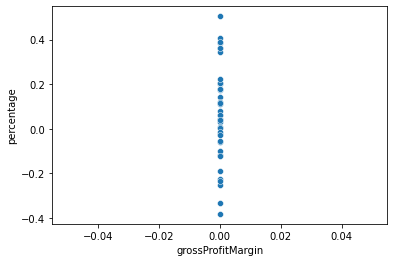

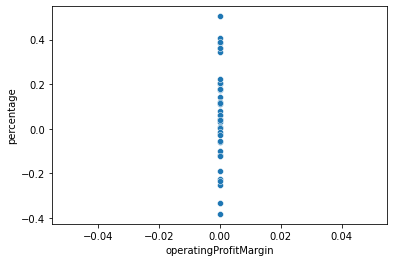

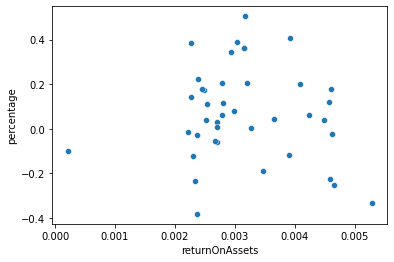

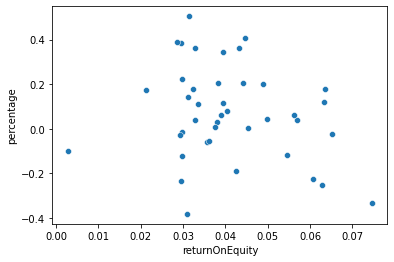

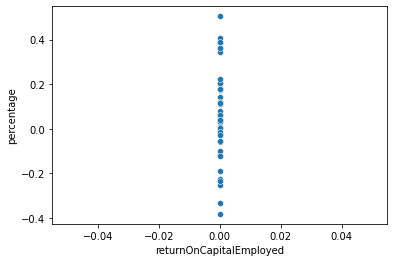

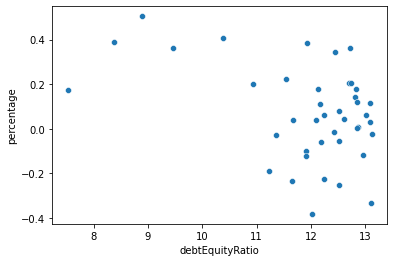

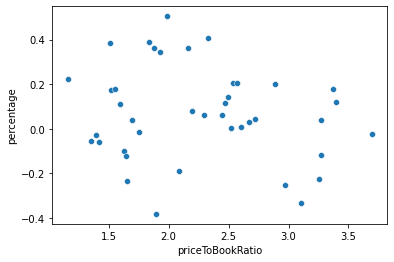

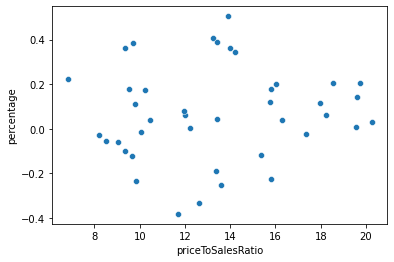

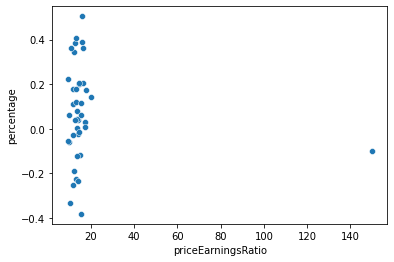

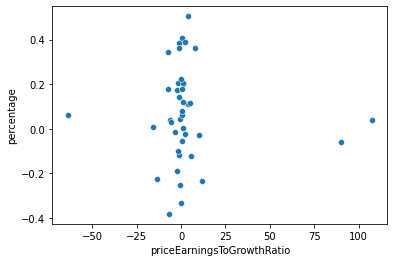

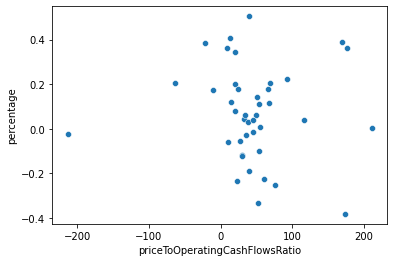

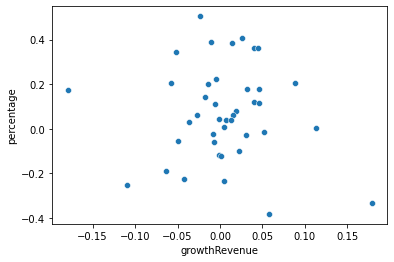

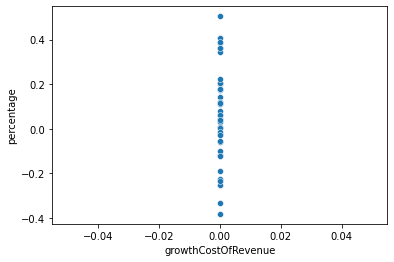

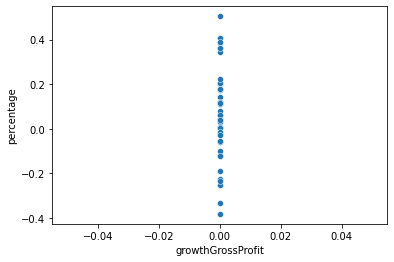

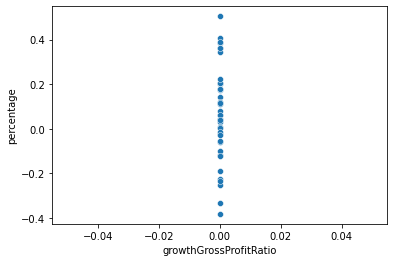

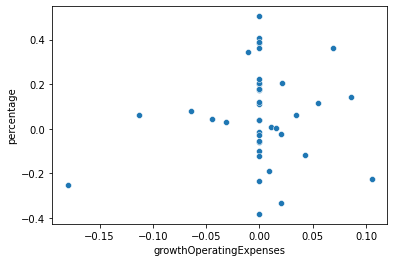

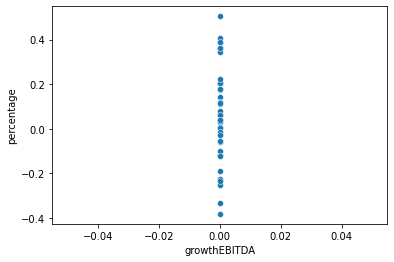

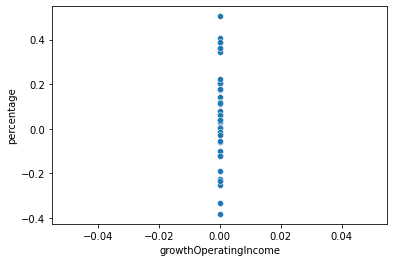

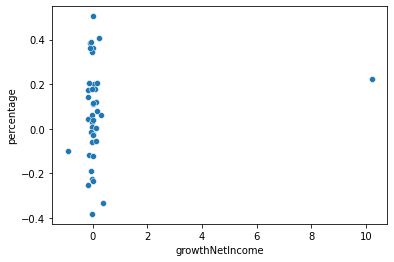

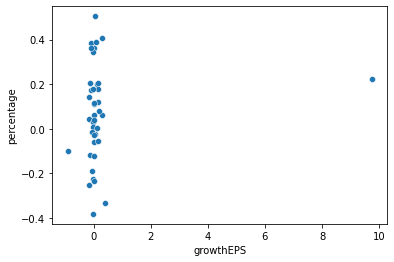

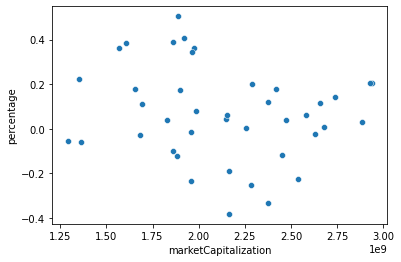

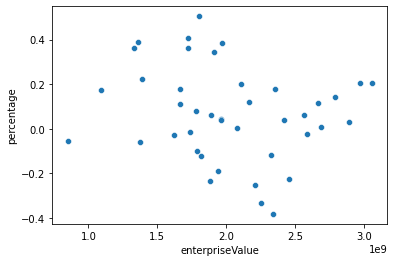

In [46]:
for colName in XReduced:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Plot Features to Examine Distributions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

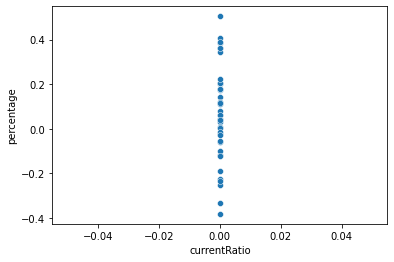

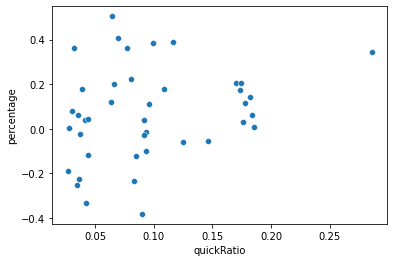

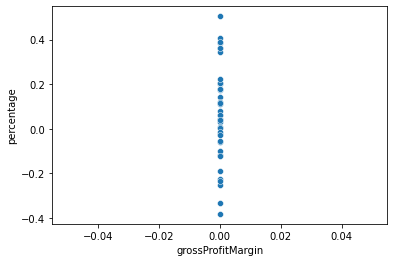

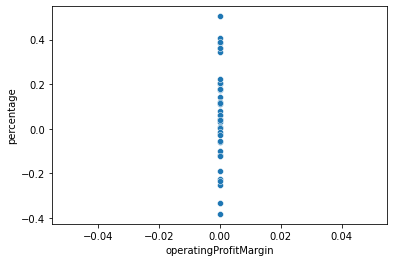

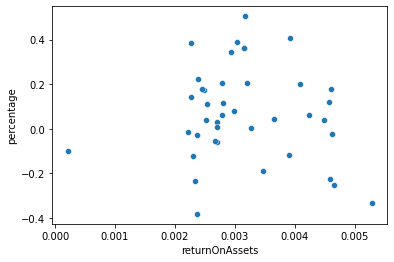

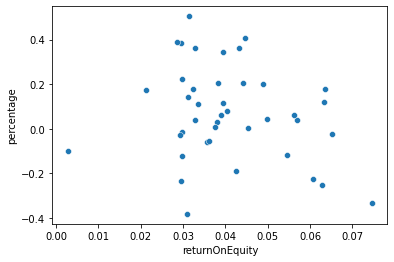

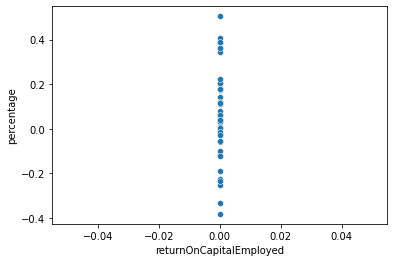

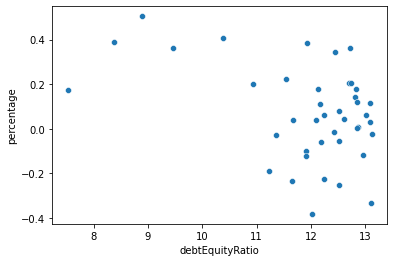

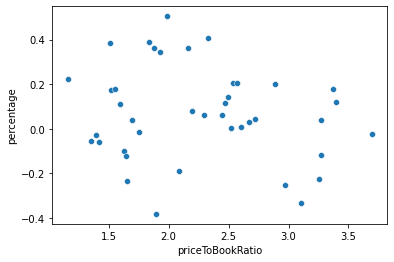

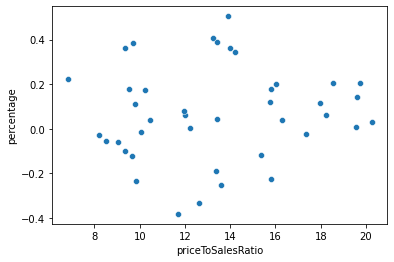

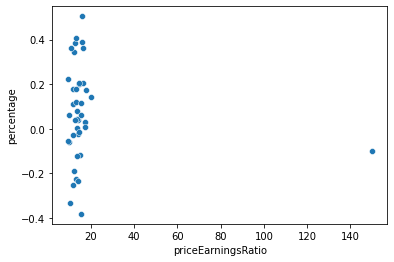

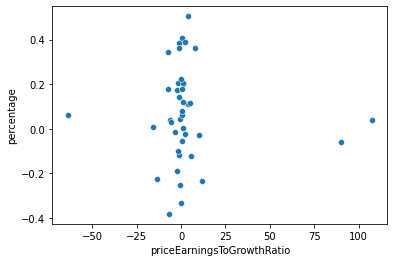

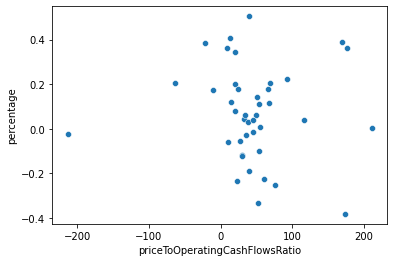

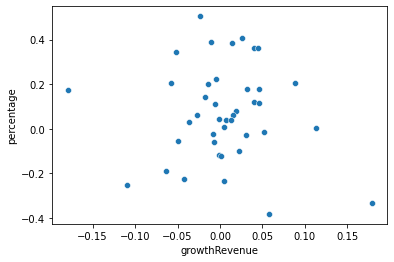

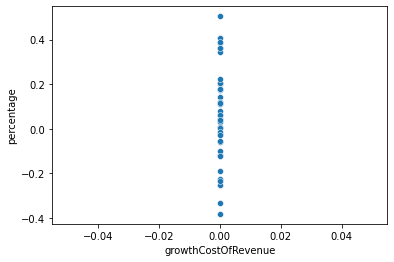

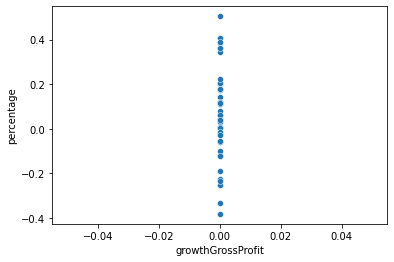

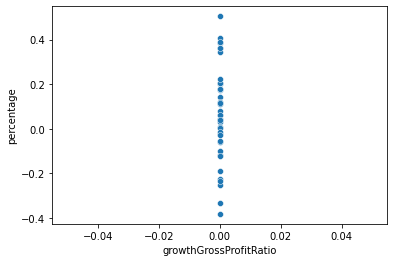

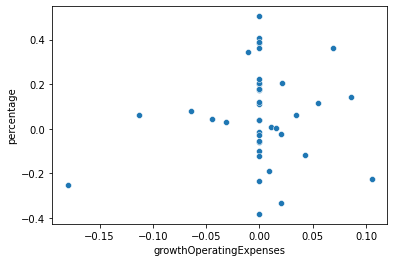

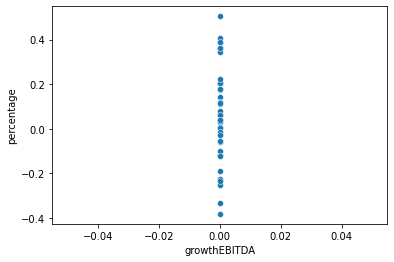

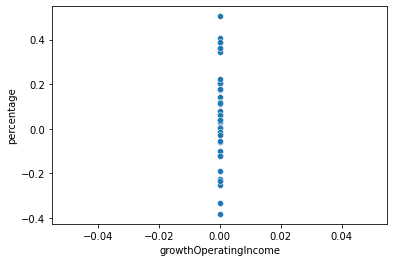

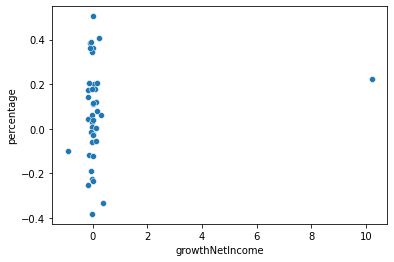

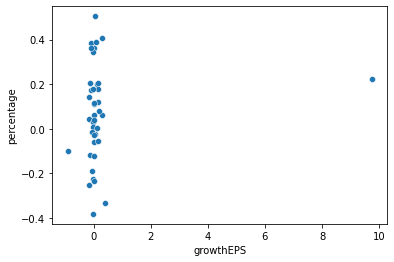

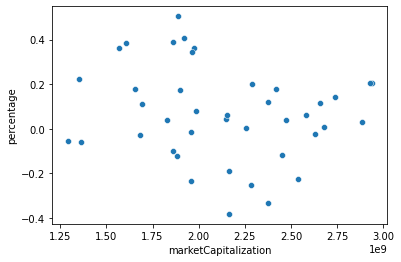

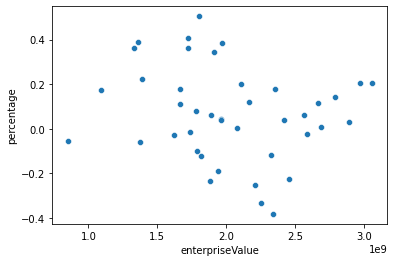

In [47]:
# plt.figure()
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Scaling/ Normalization

In [48]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,0.0,-0.866895,0.0,0.0,0.791608,0.982816,0.0,0.789236,1.518877,0.558555,-0.100820,-0.161902,-0.214884,-0.089104,0.0,0.0,0.0,0.919469,0.0,0.0,-0.242602,-0.245719,0.748541,0.586508
1,0.0,0.058276,0.0,0.0,-0.906250,-0.824963,0.0,-0.005779,-1.133616,-1.004544,-0.203921,-0.170054,-0.993894,0.167957,0.0,0.0,0.0,-0.024741,0.0,0.0,-0.211502,-0.222276,-1.213938,-0.112754
2,0.0,-0.498638,0.0,0.0,0.985188,0.571570,0.0,-0.785171,0.944836,0.747183,-0.110232,-0.061367,-0.376754,-0.333847,0.0,0.0,0.0,-0.024741,0.0,0.0,-0.117450,-0.084771,0.372932,0.159111
3,0.0,-0.909344,0.0,0.0,1.403080,1.159690,0.0,-0.203242,1.521603,0.818756,-0.131036,-0.361870,1.066724,0.053438,0.0,0.0,0.0,-0.024741,0.0,0.0,-0.168073,-0.175133,0.800604,0.771549
4,0.0,0.010840,0.0,0.0,-0.628389,-0.532958,0.0,0.177569,-1.005927,-0.970881,-0.247407,0.037447,0.131558,-0.189992,0.0,0.0,0.0,-0.024741,0.0,0.0,-0.131388,-0.138314,-1.016953,-0.722599


## Reduce Dimensionality with PCA

In [49]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:74: RuntimeWarning: divide by zero encountered in log
  pv = -np.log(v) * n_samples * (n_features - rank) / 2.
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  (1. / spectrum_[j] - 1. / spectrum_[i])) + log(n_samples)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:87: RuntimeWarning: invalid value encountered in double_scalars
  ll = pu + pl + pv + pp - pa / 2. - rank * log(n_samples) / 2.


(41, 23)

## Examine Distribution on 1st Principle Component

In [27]:
# plt.scatter(X_pc[:,0], Y)
print(X_pc[:,0].shape)
print(Y.shape)
print(Y)

(41,)
(41, 1)
    percentage
0    -0.116738
1     0.383013
4     0.202370
6     0.041693
7     0.110787
8     0.205959
10    0.504221
11    0.041842
12    0.407087
13   -0.381228
14   -0.101562
15    0.063849
16    0.143802
17    0.388615
18    0.173812
19    0.031794
20    0.178571
21   -0.058824
22    0.177861
23    0.364103
24    0.081367
25   -0.123360
26   -0.222825
27    0.206210
28    0.060529
30    0.009899
31   -0.189670
34   -0.250418
35   -0.233333
36    0.003187
37    0.037838
39   -0.334544
40   -0.022660
41   -0.015152
42    0.342565
43    0.122291
44    0.224719
46   -0.054167
47    0.115504
48    0.362947
49   -0.026946


## Transform Data to Polynomial Features, Train Models, and Plot Error

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 5):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            print("Poly Shape = ")
            print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

X Shape = 
(41, 24)
Poly Shape = 
(41, 25)
X Shape = 
(41, 24)
Poly Shape = 
(41, 325)
X Shape = 
(41, 24)
Poly Shape = 
(41, 2925)
X Shape = 
(41, 24)
Poly Shape = 
(41, 20475)
X Shape = 
(41, 23)
Poly Shape = 
(41, 24)
X Shape = 
(41, 23)
Poly Shape = 
(41, 300)
X Shape = 
(41, 23)
Poly Shape = 
(41, 2600)
X Shape = 
(41, 23)
Poly Shape = 
(41, 17550)


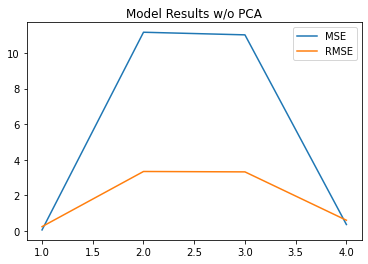

MSEs: [0.059250484442984426, 11.160632698964557, 11.013856027020841, 0.3628189178522166]
RMSEs: [0.24341422399478718, 3.3407533130963976, 3.3187130076312474, 0.6023445175746324]

1's top 3 weights were [31.82087374  1.54674715  0.26399874]
at [ 6 14 21]
2's top 3 weights were [6.24830329e-08 5.96023390e-08 5.34293753e-08]
at [302 269  71]
3's top 3 weights were [1.70286968e-18 1.33476845e-18 7.46273658e-19]
at [2107 2468 2242]
4's top 3 weights were [2.10385530e-28 2.08670870e-28 1.94865492e-28]
at [16596  7824 19759]


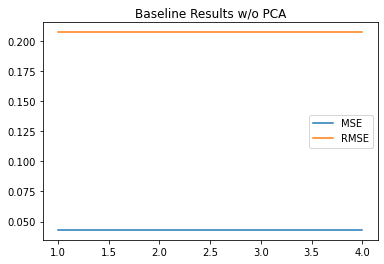

MSEs: [0.04300403632909847, 0.04300403632909847, 0.04300403632909847, 0.04300403632909847]
RMSEs: [0.20737414575857444, 0.20737414575857444, 0.20737414575857444, 0.20737414575857444]



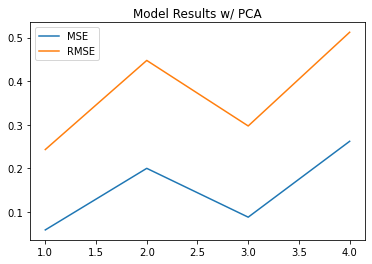

MSEs: [0.05925048429304658, 0.2003328889756535, 0.08847119828616049, 0.26232232893192975]
RMSEs: [0.2434142236867981, 0.4475856219492015, 0.29744108372274414, 0.5121741197404743]

1's top 3 weights were [0.06172157 0.03302761 0.02221648]
at [4 8 3]
2's top 3 weights were [0.08057852 0.07229199 0.06638846]
at [164 166 112]
3's top 3 weights were [0.02769956 0.0219812  0.01849315]
at [442 164 440]
4's top 3 weights were [0.01425646 0.01175804 0.01075584]
at [2742 2740 2602]


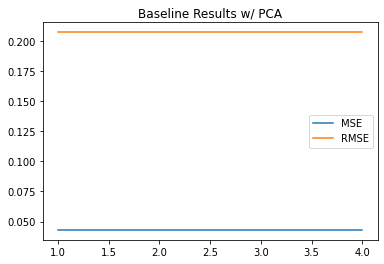

MSEs: [0.04300403632909847, 0.04300403632909847, 0.04300403632909847, 0.04300403632909847]
RMSEs: [0.20737414575857444, 0.20737414575857444, 0.20737414575857444, 0.20737414575857444]



In [29]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Train Neural Net Model

In [30]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

def trainAndGetResultsNN(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 2):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            
            # poly_features = X
            poly = PolynomialFeatures(degree=1)
            poly_features = poly.fit_transform(X)
            
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            learning_rate_init = 0.001 / (1 * 30.0) # 30 yields best results
            epsilon = 1 * 10 ** -(2) # 1e-2 yields best results
            # epsilon = 1e-8
            clf = MLPRegressor(random_state=1, max_iter=50000, learning_rate_init=learning_rate_init, epsilon=epsilon)
            clf.fit(X_train, Y_train.values.ravel()) # Y_train.values.ravel()
            Y_pred = clf.predict(X_test)
            
    
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResultsNN = trainAndGetResultsNN(X)
baselineBaseResultsNN = trainAndGetResultsNN(X, baseline=True)
truePcResultsNN = trainAndGetResultsNN(X_pc)
baselinePcResultsNN = trainAndGetResultsNN(X_pc, baseline=True)

X Shape = 
(41, 24)
X Shape = 
(41, 23)


## Plot Neural Net Model

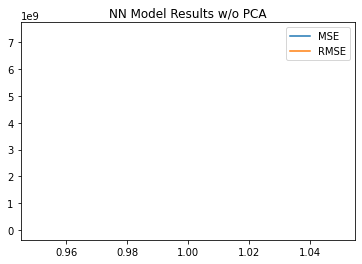

MSEs: [7380545439.7706995]
RMSEs: [85910.10091817318]



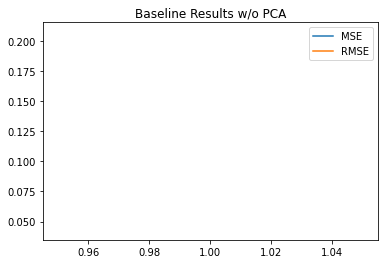

MSEs: [0.04300403632909847]
RMSEs: [0.20737414575857444]



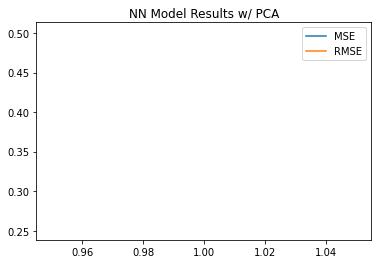

MSEs: [0.2509730198793584]
RMSEs: [0.5009720749496507]



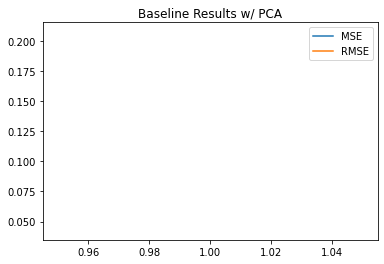

MSEs: [0.04300403632909847]
RMSEs: [0.20737414575857444]



In [31]:
def plotResultsNN(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    """for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))"""

plotResultsNN(trueBaseResultsNN, "NN Model Results w/o PCA")
plotResultsNN(baselineBaseResultsNN, "Baseline Results w/o PCA")
plotResultsNN(truePcResultsNN, "NN Model Results w/ PCA")
plotResultsNN(baselinePcResultsNN,"Baseline Results w/ PCA")

## Real-World Results

In [32]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
final_pca = PCA(n_components=21)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request...
Request result: 
<Response [200]>
Making API call request.

In [33]:
print(api.getNumApiCalls())

136


In [34]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [35]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,priceEarningsRatio,priceEarningsToGrowthRatio,priceToOperatingCashFlowsRatio,growthRevenue,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.603645,1.311136,0.469580,0.122611,0.034282,0.064734,0.078216,0.888309,3.427961,4.169088,13.238629,-0.094061,22.266278,-0.043250,0.002847,-0.086424,-0.045126,0.319706,-1.151828,-1.475884,-1.405034,-1.407446,7.154155e+09,6.523655e+09
1,2.372470,1.485405,0.541808,0.136318,0.047667,0.097405,0.109544,1.043428,3.272193,3.017526,8.398447,0.282528,22.282349,0.196443,0.000000,0.000000,0.000000,0.000000,-0.809486,-0.847781,0.000000,0.297260,5.055865e+09,4.339565e+09
2,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,13.994552,0.581428,-117.575442,0.149466,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09
3,2.352882,2.215695,0.612933,0.203260,0.016118,0.043363,0.031190,1.690307,5.573498,19.466146,32.132857,-1.927971,47.409632,0.004043,0.033282,-0.013584,-0.017556,0.122110,-0.127325,-0.206890,-0.168797,-0.166667,4.012751e+11,4.484521e+11
4,4.154092,3.818327,0.844927,0.474154,0.037512,0.047939,0.060583,0.277959,4.450948,33.109143,23.211358,2.683918,62.223588,-0.082660,-0.402655,0.017366,0.109039,-0.105603,0.150816,0.139920,0.094828,0.086483,2.594101e+11,2.551101e+11


(104, 24)
(104, 1)


In [36]:
# print(truePcResults['clf'][0])
print(spy_X_poly.shape)
print(spy_X_pc_poly.shape)

(104, 25)
(104, 22)


In [37]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

ValueError: ignored

In [ ]:
r1 = trueBaseResultsNN['clf'][0].predict(spy_X_poly)
# r2 = truePcResultsNN['clf'][0].predict(spy_X_pc_poly)
r2 = truePcResultsNN['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)